In [1]:
%load_ext autoreload
%autoreload 2

import particle as pt
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mplhep
from scipy.stats import norm
from scipy.optimize import curve_fit
import matplotlib.mlab as mlab
import time
from matplotlib.colors import LogNorm
mplhep.style.use(mplhep.style.ROOT)
from pprint import pprint
from tqdm import tqdm
import polars as pl
import sys
import os
import particle
# using getlogin() returning username
user_name = os.getlogin()

sys.path.append(f'/home/{user_name}/Documents/cernbox/Atmos_Pandora/apc_atmo_repo/Anatree/')
from anatree_class import Anatree
from  ana_tools import *


plt.rcParams.update({'font.size': 16,
                     'grid.linestyle': '--',
                     'axes.grid': True,
                     'figure.autolayout': True,
                     'figure.figsize': [14,6]
                     })

anatree:Anatree

In [2]:
anatree = Anatree("/home/henrique/Documents/cernbox/Atmos_Pandora/data/atm_50k_hd_AV_2.5_random/anatree_hd_AV_2dot5_random_sum_300k_new.root", entry_start=0, entry_stop=1000, load_data=False)
anatree.tree:uproot.TTree
anatree.read_parquet('../../../../../data/atm_50k_hd_AV_2.5_random/parquet_new',batches=-1, concat=False)#, types=['nu','reco_tracks','reco_showers'])#, n_rows=100)

Reading nu files... 30/30
Reading geant files... 30/30
Reading reco_tracks files... 30/30
Reading reco_showers files... 30/30
Reading pfp files... 30/30


In [3]:
nu = anatree.nu
geant = anatree.geant
shw = anatree.reco_showers
tracks = anatree.reco_tracks
showers = anatree.reco_showers
merged:pl.DataFrame
merged = 0
merged = pl.read_parquet('../../../../../data/atm_50k_hd_AV_2.5_random/reco_geant_nu.pasquet')
# for i,n in enumerate(nu):
#     df = anatree.get_full_reco_tracks(tracks[i], geant[i], nu[i])
#     df = df.collect()
#     if i == 0:
#         merged = df
#     else:
#         merged = pl.concat([merged,df])

In [4]:
anatree2 = Anatree("/home/henrique/Documents/cernbox/Atmos_Pandora/data/atm_50k_hd_AV_2.5_random/anatree_merged.root", entry_start=0, entry_stop=1000, load_data=False)
anatree2.tree:uproot.TTree
anatree2.read_parquet('../../../../../data/atm_50k_hd_AV_2.5_random/parquet_new_test',batches=-1, concat=False)#, types=['nu','reco_tracks','reco_showers'])#, n_rows=100)

Reading nu files... 30/30
Reading geant files... 30/30
Reading reco_tracks files... 30/30
Reading reco_showers files... 30/30
Reading pfp files... 30/30


In [5]:
merged2:pl.DataFrame
merged2 = 0
for i,n in enumerate(nu):
    df = anatree2.get_full_reco_tracks(anatree2.reco_tracks[i], anatree2.geant[i], anatree2.nu[i])
    df = df.collect()
    if i == 0:
        merged2 = df
    else:
        merged2 = pl.concat([merged2,df])

In [6]:
no_g = merged2.filter(
    pl.col('trkTruthMatch_pandoraTrack') < 0
)
no_g
events_no_g = no_g.join(merged, on=selection_events(['trkId_pandoraTrack']),how='inner').select(
    pl.all()
)

events_no_g.group_by('pdg_geant_right').agg(
    pl.count(),
    pl.col('Mother_geant_right').filter(pl.col('Mother_geant_right')==0).count().alias('mothers')
)
events_no_g



subrun,event,trkId_pandoraTrack,trkke_pandoraTrack_x,trkke_pandoraTrack_y,trkke_pandoraTrack_z,trkrange_pandoraTrack_x,trkrange_pandoraTrack_y,trkrange_pandoraTrack_z,trkidtruth_pandoraTrack_x,trkidtruth_pandoraTrack_y,trkidtruth_pandoraTrack_z,trkorigin_pandoraTrack_x,trkorigin_pandoraTrack_y,trkorigin_pandoraTrack_z,trkpdgtruth_pandoraTrack_x,trkpdgtruth_pandoraTrack_y,trkpdgtruth_pandoraTrack_z,trkefftruth_pandoraTrack_x,trkefftruth_pandoraTrack_y,trkefftruth_pandoraTrack_z,trkpurtruth_pandoraTrack_x,trkpurtruth_pandoraTrack_y,trkpurtruth_pandoraTrack_z,trkpitchc_pandoraTrack_x,trkpitchc_pandoraTrack_y,trkpitchc_pandoraTrack_z,ntrkhits_pandoraTrack_x,ntrkhits_pandoraTrack_y,ntrkhits_pandoraTrack_z,trkstartx_pandoraTrack,trkstarty_pandoraTrack,trkstartz_pandoraTrack,trkstartd_pandoraTrack,trkendx_pandoraTrack,trkendy_pandoraTrack,trkendz_pandoraTrack,…,StartPointy_drifted_geant_right,StartPointz_drifted_geant_right,StartT_drifted_geant_right,StartE_drifted_geant_right,StartP_drifted_geant_right,StartPx_drifted_geant_right,StartPy_drifted_geant_right,StartPz_drifted_geant_right,EndPointx_drifted_geant_right,EndPointy_drifted_geant_right,EndPointz_drifted_geant_right,EndT_drifted_geant_right,EndE_drifted_geant_right,EndP_drifted_geant_right,EndPx_drifted_geant_right,EndPy_drifted_geant_right,EndPz_drifted_geant_right,NumberDaughters_geant_right,Mother_geant_right,MergedId_geant_right,origin_geant_right,MCTruthIndex_geant_right,process_primary_geant_right,processname_geant_right,nuPDG_truth_right,ccnc_truth_right,nuvtxx_truth_right,nuvtxy_truth_right,nuvtxz_truth_right,enu_truth_right,nu_dcosx_truth_right,nu_dcosy_truth_right,nu_dcosz_truth_right,mode_truth_right,nuvtxx_right,nuvtxy_right,nuvtxz_right
i32,i32,i16,f32,f32,f32,f32,f32,f32,i32,i32,i32,i16,i16,i16,i32,i32,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i16,i16,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i32,i32,i32,i32,i32,i32,str,i32,i32,f32,f32,f32,f32,f32,f32,f32,i32,f32,f32,f32
10002,11,2,1628.034912,-99999.0,73.958702,49.470959,-99999.0,33.89423,-1,-1,1,-1,-1,1,-99999,-99999,-11,-99999.0,-99999.0,0.001718,-1.0,-1.0,0.966801,54.182587,-99999.0,0.831507,41,-9999,41,287.784515,-122.253021,1276.747925,75.591537,265.667999,-83.77256,1303.227905,…,-383.71405,1247.244019,0.0,43.780979,43.780979,-12.321998,-41.861351,3.545389,255.144257,-468.916687,1259.853271,0.0,0.000511,0.0,-0.0,-0.0,-0.0,59,0,0,1,0,1,"""primary""",-12,0,277.504669,-383.71405,1247.244019,60.619392,-0.320432,-0.942778,0.092168,2,276.72403,-383.353912,1248.42334
10011,11,0,-999.0,12.969635,-99999.0,-999.0,1.401249,-99999.0,98,98,-1,1,1,-1,2212,2212,-99999,0.806252,1.096889,-99999.0,0.732082,1.0,-1.0,0.0,0.467062,-99999.0,0,4,-9999,-40.398132,571.048523,539.152771,36.780228,-40.445011,570.207581,540.272644,…,570.782776,539.909241,4.821255,0.961845,0.211641,0.11295,-0.112489,-0.139214,-40.597473,570.447266,539.519531,4.821255,0.938272,0.0,0.0,-0.0,-0.0,0,4,0,1,0,0,"""neutronInelast…",12,1,19.320396,598.492859,555.296326,0.580539,-0.461478,-0.793472,0.396794,0,-40.418159,570.55542,539.485596
10027,18,5,-999.0,9.438737,-999.0,-999.0,1.426129,-999.0,5,6,6,1,1,1,2212,2212,2212,1.244788,0.359437,0.437178,0.276271,0.750672,0.966685,0.0,0.739027,0.0,0,3,0,13.478891,95.715286,725.517578,349.897156,13.198042,94.292526,725.409241,…,93.685555,725.151001,0.0,1.004795,0.359526,0.300855,-0.158032,0.11735,16.506111,91.897346,726.317261,0.0,0.938272,0.0,0.0,-0.0,0.0,0,0,0,1,0,1,"""primary""",12,0,13.375447,93.685555,725.151001,19.04892,-0.695951,-0.241058,0.676428,2,13.573974,95.745537,724.141846
10073,6,2,72.328423,57.070866,72.311577,5.57643,4.774336,3.933972,11,11,11,1,1,1,2212,2212,2212,0.685624,0.719931,0.781428,0.945202,0.998327,0.989263,14.602364,2.763112,3.872656,11,8,3,-36.612125,590.791748,462.578979,17.037003,-30.343012,591.538208,461.792023,…,591.062561,462.39032,0.0,1.029725,0.424239,0.421398,-0.028855,-0.039618,-30.428566,591.061768,461.91037,0.0,0.938272

In [7]:
filter_d = events_no_g.filter(pl.col('pdg_geant_right').abs()==13).select(selection_events())

g4 = merge_same_df(anatree.geant, None, None, df_concat=filter_d, on=selection_events(), how='inner')


In [8]:
pl.Config.set_tbl_cols(20)
print(merged.filter(get_event(3181,5)).select(
    pl.col('^*_truth$'),
    pl.col('has_valid_pfp'),
    pl.col('pdg_geant'),
    pl.col('trkPFParticleID_pandoraTrack')
))
events_no_g.filter(pl.col('pdg_geant_right').abs()==13).select(selection_events(['trkPFParticleID_pandoraTrack']))

shape: (3, 13)
┌─────┬─────┬─────┬────────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┐
│ nuP ┆ ccn ┆ nuv ┆ nuvtxy ┆ nuvtx ┆ enu_t ┆ nu_dc ┆ nu_dc ┆ nu_dc ┆ mode_ ┆ has_v ┆ pdg_g ┆ trkPF │
│ DG_ ┆ c_t ┆ txx ┆ _truth ┆ z_tru ┆ ruth  ┆ osx_t ┆ osy_t ┆ osz_t ┆ truth ┆ alid_ ┆ eant  ┆ Parti │
│ tru ┆ rut ┆ _tr ┆ ---    ┆ th    ┆ ---   ┆ ruth  ┆ ruth  ┆ ruth  ┆ ---   ┆ pfp   ┆ ---   ┆ cleID │
│ th  ┆ h   ┆ uth ┆ f32    ┆ ---   ┆ f32   ┆ ---   ┆ ---   ┆ ---   ┆ i32   ┆ ---   ┆ i32   ┆ _pand │
│ --- ┆ --- ┆ --- ┆        ┆ f32   ┆       ┆ f32   ┆ f32   ┆ f32   ┆       ┆ i16   ┆       ┆ oraTr │
│ i32 ┆ i32 ┆ f32 ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆ ack   │
│     ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆ ---   │
│     ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆ i16   │
╞═════╪═════╪═════╪════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪

subrun,event,trkPFParticleID_pandoraTrack
i32,i32,i16
14601,1,2
2119,10,7
3181,5,2
5704,16,1
7234,16,0
8083,5,1
8294,5,1
899,19,3
11729,13,1


In [9]:
nu = merge_same_df(anatree.nu)

for subrun, event in filter_d.to_numpy():
    nodes = make_tree(g4.lazy(), subrun, event)
    print_tree(nu, g4.lazy(), nodes, subrun, event, maxlevel=2, P='P_geant')

0: nu(mu) E = 3.73 GeV 
├── 1: mu- P = 1.79; 
├── 2: n P = 1.45; 
├── 3: p P = 0.19; 
└── 4: pi+ P = 1.09; 
0: nu(e) E = 49.73 GeV 
├── 1: gamma P = 0.00; 
├── 2: e- P = 35.67; 
├── 3: pi0 P = 9.69; 
├── 4: p P = 0.59; 
├── 5: pi+ P = 0.11; 
├── 6: pi- P = 0.35; 
├── 7: Lambda P = 2.41; 
├── 8: pi0 P = 0.33; 
├── 9: K+ P = 1.02; 
├── 10: n P = 0.34; 
├── 11: n P = 0.32; 
├── 12: n P = 0.31; 
├── 13: n P = 0.33; 
├── 14: n P = 0.28; 
├── 15: n P = 0.23; 
├── 16: n P = 0.31; 
└── 17: n P = 0.18; 
0: nu(mu)~ E = 0.86 GeV 
├── 1: gamma P = 0.01; 
├── 2: mu+ P = 0.57; 
└── 3: Lambda P = 0.43; 
0: nu(mu) E = 0.98 GeV 
├── 1: mu- P = 0.50; 
├── 2: p P = 0.52; 
├── 3: p P = 0.18; 
├── 4: p P = 0.10; 
├── 5: p P = 0.18; 
├── 6: p P = 0.07; 
├── 7: p P = 0.23; 
├── 8: p P = 0.19; 
├── 9: p P = 0.15; 
├── 10: n P = 0.26; 
├── 11: n P = 0.17; 
├── 12: n P = 0.14; 
├── 13: n P = 0.24; 
├── 14: n P = 0.12; 
├── 15: n P = 0.23; 
├── 16: n P = 0.03; 
├── 17: n P = 0.17; 
├── 18: n P = 0.25; 
├── 19: n

In [10]:
combined = merged.join(merged2, on=selection_events(['trkId_pandoraTrack']), how='inner')

In [11]:
combined.filter(
    pl.col('pdg_geant') != pl.col('pdg_geant_right')
).select(
    selection_events(['pdg_geant', 'pdg_geant_right'])
# ).group_by('pdg_geant_right').agg(
#     pl.count()
)

subrun,event,pdg_geant,pdg_geant_right
i32,i32,i32,i32
0,4,2212,-211
10001,2,211,-11
10001,6,211,-11
10002,7,1000010020,2212
10002,10,-11,22
10002,11,2212,-11
10002,19,2212,22
10005,6,1000010030,-211
10005,8,2212,11


In [12]:
def extract_info(df:pl.DataFrame):
        df = df.filter(
                pl.col('has_valid_pfp')==1
        # ).filter
        #         check_fiducial('pandoraTrack')
        )
        df = df.with_columns(
                dist_vtx = (
                        (pl.col('nuvtxx')- pl.col('nuvtxx_truth'))**2 + 
                        (pl.col('nuvtxy')- pl.col('nuvtxy_truth'))**2 + 
                        (pl.col('nuvtxz')- pl.col('nuvtxz_truth'))**2
                ).sqrt(),
                dx = 0,
                dy = 0,
                dz = 0,
                # dx = (pl.col('nuvtxx')- pl.col('nuvtxx_truth')),
                # dy = (pl.col('nuvtxy')- pl.col('nuvtxy_truth')),
                # dz = (pl.col('nuvtxz')- pl.col('nuvtxz_truth')),
        ).with_columns(
                dist_to_vtx = (
                        (pl.col('trkstartx_pandoraTrack') - pl.col('dx') - pl.col('nuvtxx_truth'))**2 + 
                        (pl.col('trkstarty_pandoraTrack') - pl.col('dx') - pl.col('nuvtxy_truth'))**2 + 
                        (pl.col('trkstartz_pandoraTrack') - pl.col('dx') - pl.col('nuvtxz_truth'))**2
                ).sqrt(),
                dist_vtx = (
                        (pl.col('nuvtxx')- pl.col('nuvtxx_truth'))**2 + 
                        (pl.col('nuvtxy')- pl.col('nuvtxy_truth'))**2 + 
                        (pl.col('nuvtxz')- pl.col('nuvtxz_truth'))**2
                ).sqrt(),
                dist_g_start = (
                        (pl.col('trkstartx_pandoraTrack') - pl.col('dx')- pl.col('StartPointx_drifted_geant'))**2 + 
                        (pl.col('trkstarty_pandoraTrack') - pl.col('dx')- pl.col('StartPointy_drifted_geant'))**2 + 
                        (pl.col('trkstartz_pandoraTrack') - pl.col('dx')- pl.col('StartPointz_drifted_geant'))**2
                ).sqrt(),
                dist_g_end = (
                        (pl.col('trkendx_pandoraTrack') - pl.col('dx')- pl.col('EndPointx_drifted_geant'))**2 + 
                        (pl.col('trkendy_pandoraTrack') - pl.col('dx')- pl.col('EndPointy_drifted_geant'))**2 + 
                        (pl.col('trkendz_pandoraTrack') - pl.col('dx')- pl.col('EndPointz_drifted_geant'))**2
                ).sqrt(),
                line_reco = (
                        (pl.col('trkstartx_pandoraTrack') - pl.col('dx')- pl.col('trkendx_pandoraTrack'))**2 + 
                        (pl.col('trkstarty_pandoraTrack') - pl.col('dx')- pl.col('trkendy_pandoraTrack'))**2 + 
                        (pl.col('trkstartz_pandoraTrack') - pl.col('dx')- pl.col('trkendz_pandoraTrack'))**2
                ).sqrt(),
                line_g = (
                        (pl.col('StartPointx_drifted_geant') - pl.col('dx')- pl.col('EndPointx_drifted_geant'))**2 + 
                        (pl.col('StartPointy_drifted_geant') - pl.col('dx')- pl.col('EndPointy_drifted_geant'))**2 + 
                        (pl.col('StartPointz_drifted_geant') - pl.col('dx')- pl.col('EndPointz_drifted_geant'))**2
                ).sqrt(),
                ).with_columns(
                angle_lines = (
                        (
                        (
                                (pl.col('trkendx_pandoraTrack')- pl.col('trkstartx_pandoraTrack'))*(pl.col('EndPointx_drifted_geant')- pl.col('StartPointx_drifted_geant')) + 
                                (pl.col('trkendy_pandoraTrack')- pl.col('trkstarty_pandoraTrack'))*(pl.col('EndPointy_drifted_geant')- pl.col('StartPointy_drifted_geant')) + 
                                (pl.col('trkendz_pandoraTrack')- pl.col('trkstartz_pandoraTrack'))*(pl.col('EndPointz_drifted_geant')- pl.col('StartPointz_drifted_geant'))
                        )/(pl.col('line_reco')*pl.col('line_g'))
                        ).arccos())*180/np.pi

                ).filter(
                        True
                # (pl.col('pdg_geant').abs().is_in([13,2212,211]))# & (pl.col('Mother_geant')==0)
                # ).filter(
                #     (pl.col('dist_g_start') > 200) & (pl.col('dist_g_end')< pl.col('dist_g_start')+20) & (pl.col('dist_g_end')> pl.col('dist_g_start')-20)
                # ).filter(
                # (pl.col('ccnc_truth')==0) & (pl.col('nuPDG_truth').abs()==14)
                )
        return df

m1 = extract_info(merged)
m2 = extract_info(merged2.filter(pl.col('pdg_geant').is_not_null()))

-661.0


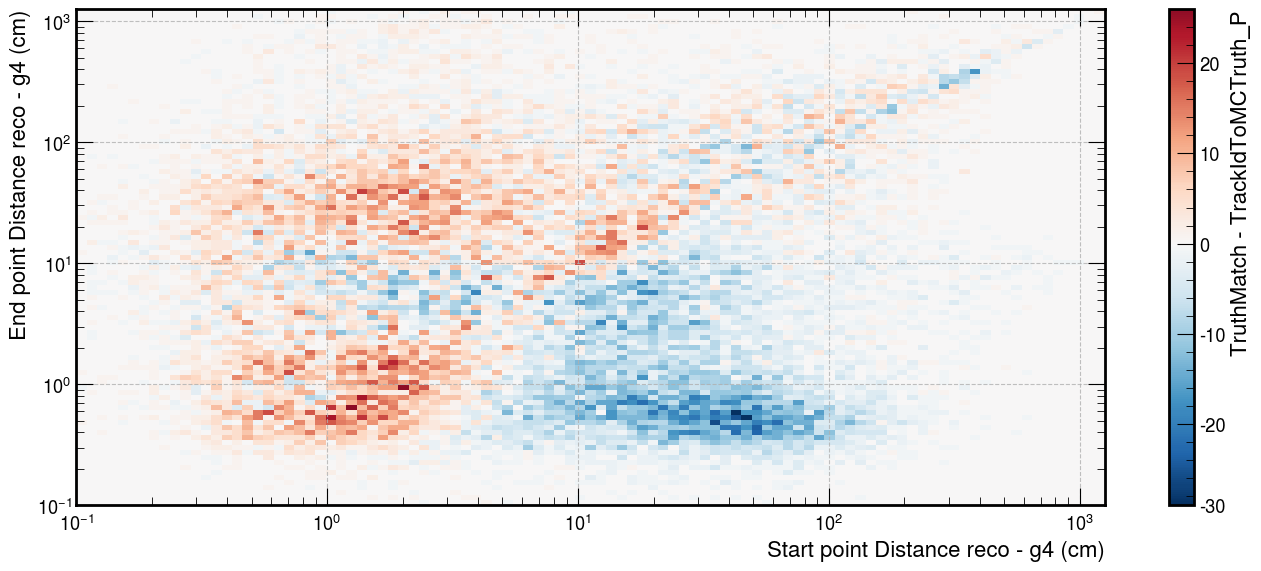

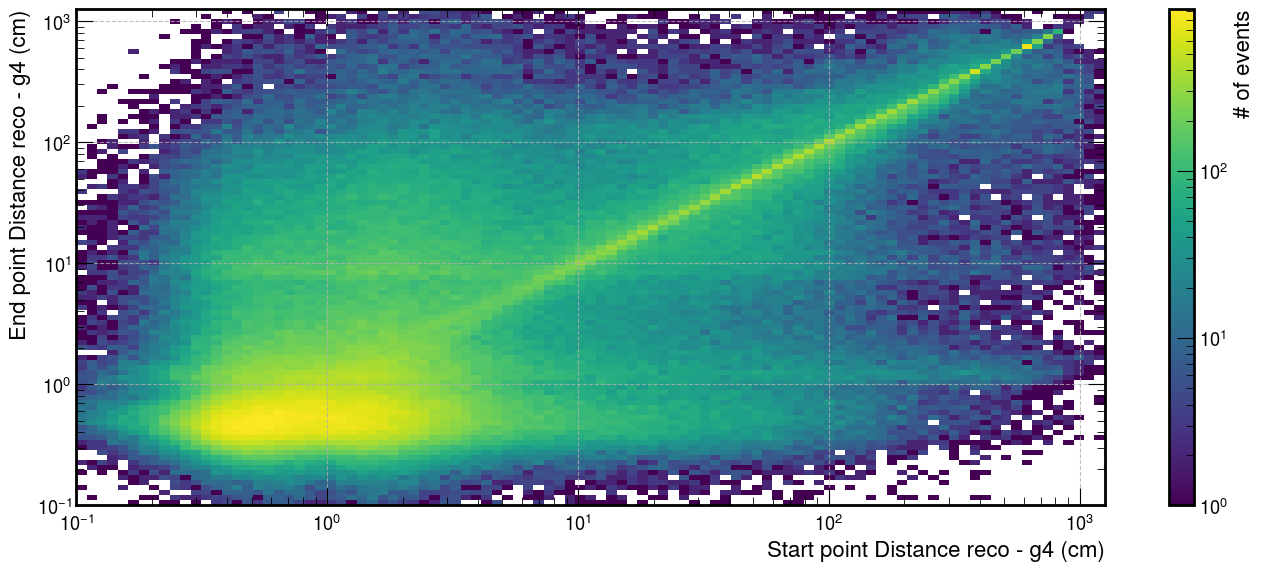

In [13]:
import matplotlib
class MidpointNormalize(matplotlib.colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        v_ext = np.max( [ np.abs(self.vmin), np.abs(self.vmax) ] )
        x, y = [-v_ext, self.midpoint, v_ext], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
binsd = np.logspace(-1,3.1,100)
# h1, xed1, yed1 = np.histogram2d(m1['dist_g_start'], m1['dist_g_end'], weights=m1['trkpurity_pandoraTrack'],bins=[binsd, binsd])
# h2, xed2, yed2 = np.histogram2d(m2['dist_g_start'], m2['dist_g_end'], weights=m2['trkpurity_pandoraTrack'],bins=[binsd, binsd])
h1, xed1, yed1 = np.histogram2d(m1['dist_g_start'], m1['dist_g_end'], bins=[binsd, binsd])
h2, xed2, yed2 = np.histogram2d(m2['dist_g_start'], m2['dist_g_end'], bins=[binsd, binsd])

H = h2-h1
cvals = H.ravel()
print(sum(cvals))

elev_min= min(cvals)
elev_max= max(cvals)
mid_val=0
cmap=matplotlib.cm.RdBu_r # set the colormap to soemthing diverging

plt.pcolormesh(xed2, yed2, H.T,
                    cmap=cmap,
                    norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max),
                    );

# plt.hist2d(, , norm='log');
plt.yscale('log')
plt.xscale('log')
plt.ylabel('End point Distance reco - g4 (cm)')
plt.xlabel('Start point Distance reco - g4 (cm)')
c=plt.colorbar()
c.set_label('TruthMatch - TrackIdToMCTruth_P')
plt.figure()

# plt.hist2d(m2['dist_g_start'], m2['dist_g_end'], bins=[binsd, binsd], norm='log');
plt.pcolormesh(xed2, yed2, h2.T, norm='log')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('End point Distance reco - g4 (cm)')
plt.xlabel('Start point Distance reco - g4 (cm)')
c=plt.colorbar()
c.set_label('# of events')
# plt.plot([0.1,1000],[0.1,1000])


In [14]:
m1.filter(
    pl.col('dist_g_start')>1.2e5
).filter(
    pl.col('pdg_geant')==13
).select(
    pl.col(selection_events()),
    pl.col('trkPFParticleID_pandoraTrack'),
    pl.col('pdg_geant'),
    pl.col('^trkstart._pandoraTrack$'),
    pl.col('^StartPoint._drifted_geant$'),
    pl.col('dist_g_start'),
# ).filter(
    # ~(pl.col('pdg_geant')==22)
)
m1.filter(
    get_event(10336,10)
).select(
    pl.col(selection_events()),
    pl.col('trkPFParticleID_pandoraTrack'),
    pl.col('pdg_geant'),
    pl.col('^trkstart._pandoraTrack$'),
    pl.col('^StartPoint._geant$'),
    pl.col('dist_g_start'),
)

subrun,event,trkPFParticleID_pandoraTrack,pdg_geant,trkstartx_pandoraTrack,trkstarty_pandoraTrack,trkstartz_pandoraTrack,trkstartd_pandoraTrack,StartPointx_geant,StartPointy_geant,StartPointz_geant,dist_g_start
i32,i32,i16,i32,f32,f32,f32,f32,f32,f32,f32,f64
10336,10,0,13,-58.939522,-561.576843,19.526808,20.403057,-59.437786,-561.09552,19.315071,172856.942346
10336,10,1,2212,-57.807217,-561.100952,19.366154,20.242403,-59.437786,-561.09552,19.315071,1.631378


In [15]:
m2['trkorigin_pandoraTrack_x'].describe()

statistic,value
str,f64
"""count""",572204.0
"""null_count""",0.0
"""mean""",0.873618
"""std""",0.486612
"""min""",-1.0
"""25%""",1.0
"""50%""",1.0
"""75%""",1.0
"""max""",1.0


In [16]:
m2.filter(get_event(10060,15)).select(
    pl.col('pdg_geant'),
    pl.col('trkPFParticleID_pandoraTrack')
)
merged['trkcompleteness_pandoraTrack']

trkcompleteness_pandoraTrack
f32
1.0
1.0
0.728269
0.63543
0.109727
0.963762
1.0
0.679795
1.0


In [29]:
shw = merge_same_df(anatree.reco_showers)

In [31]:
shw.filter(get_event(1000,12))

subrun,event,shwr_bestplane_pandoraShower,shwr_length_pandoraShower,shwr_startdcosx_pandoraShower,shwr_startdcosy_pandoraShower,shwr_startdcosz_pandoraShower,shwr_startx_pandoraShower,shwr_starty_pandoraShower,shwr_startz_pandoraShower,…,shwr_hasPFParticle_pandoraShower,shwr_PFParticleID_pandoraShower,shwr_pidmvamu_pandoraShower,shwr_pidmvae_pandoraShower,shwr_pidmvapich_pandoraShower,shwr_pidmvaphoton_pandoraShower,shwr_pidmvapr_pandoraShower,showerID_pandoraShower,pfp_parentID,has_valid_pfp
i32,i32,i16,f32,f32,f32,f32,f32,f32,f32,…,i16,i16,f32,f32,f32,f32,f32,i16,i16,i16
1000,12,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,…,1,0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,0,-1,0
